<a href="https://colab.research.google.com/github/cyrilhokage/Challenge-Dectection-Anomalies/blob/main/Challenge_Anomay_Detection_Cyrille_NOUBOUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION:

L'objectif de ce data challenge est de déterminer les anomalies  sur les mesures de l'accéléromètre d'un hélicotère, pendant 1 minute à une fréquence de 1024 Hz.

Un enregistrment est donc une série temporlle de 60 * 1024 = 61440 instants temporels équidistants.

Pour relever ce challenge et essayer de détecter le plus d'anomalies possibles, je vais tout le longe de notebook essayer diverses méthodes pour extraire les features les plus pertinentes, et pour chaque approche de transformation de feature, je testerai différents algorithmes d'apprentissage. 

Pour ce qui est de ces algorithmes, je me limiterai pour la plus-part à 3 :

  - Isolation Forest
  - Local Outlier factor
  - Kernel SVM




# Import librairies

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN, OPTICS

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Load data

In [ ]:
xtrain = np.loadtxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/airbus_train.csv', delimiter= ' ')
print(xtrain.shape)
xtest = np.loadtxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/airbus_test.csv', delimiter= ' ')
print(xtest.shape)

(1677, 61440)
(2511, 61440)


In [ ]:
X = np.concatenate((xtrain, xtest), axis=0)

# Sample plots to visualise data

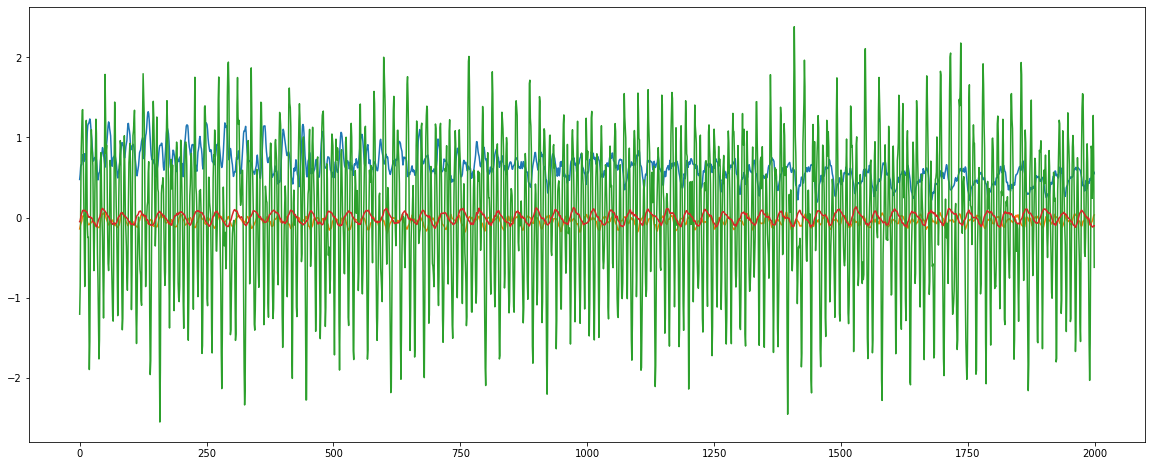

In [ ]:
plt.figure(figsize=(20,8))
#plt.plot(range(len(actual_val)), actual_val)
for i in range(4):
  plt.plot(range(2000), xtest[i,:2000])
plt.show()

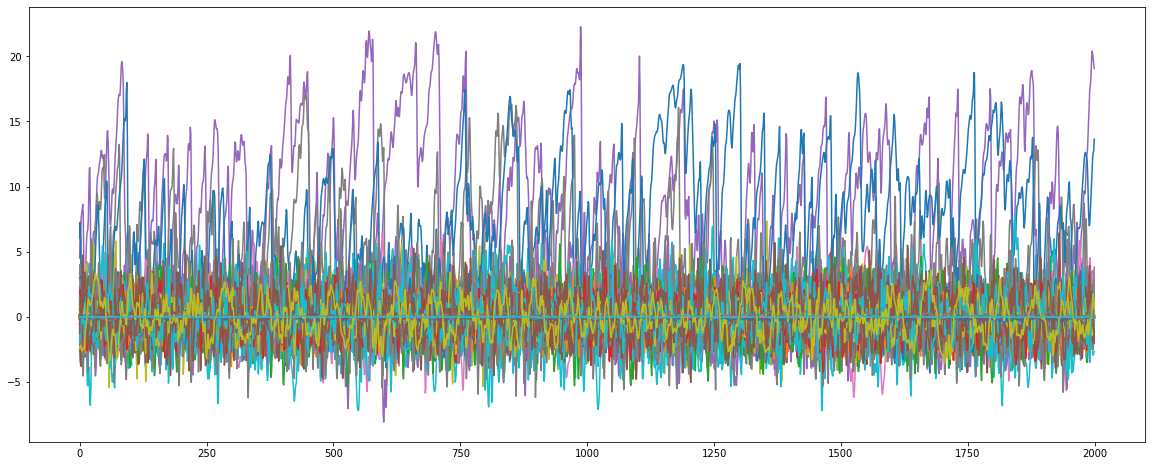

In [ ]:
plt.figure(figsize=(20,8))
#plt.plot(range(len(actual_val)), actual_val)
for i in range(200):
  plt.plot(range(2000), xtest[i,:2000])
plt.show()

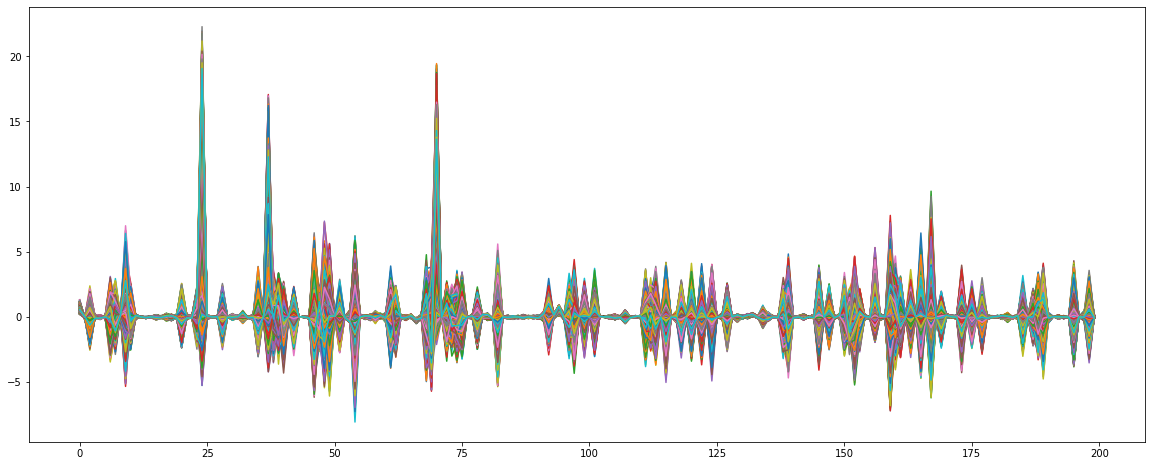

In [ ]:
plt.figure(figsize=(20,8))
#plt.plot(range(len(actual_val)), actual_val)
plt.plot(range(len(xtest[:200,:2000])), xtest[:200,:2000])
plt.show()

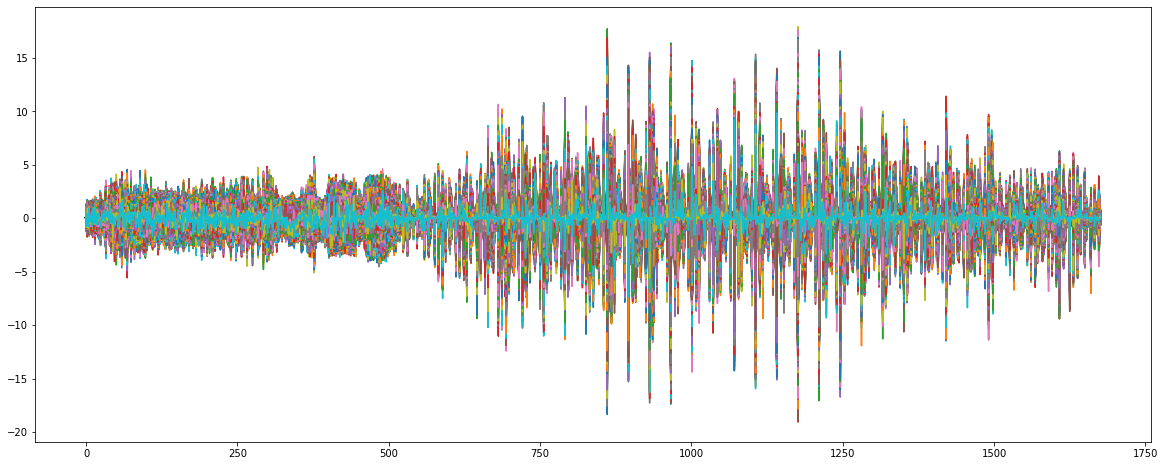

In [ ]:
plt.figure(figsize=(20,8))
#plt.plot(range(len(actual_val)), actual_val)
plt.plot(range(len(xtrain)), xtrain)
plt.show()

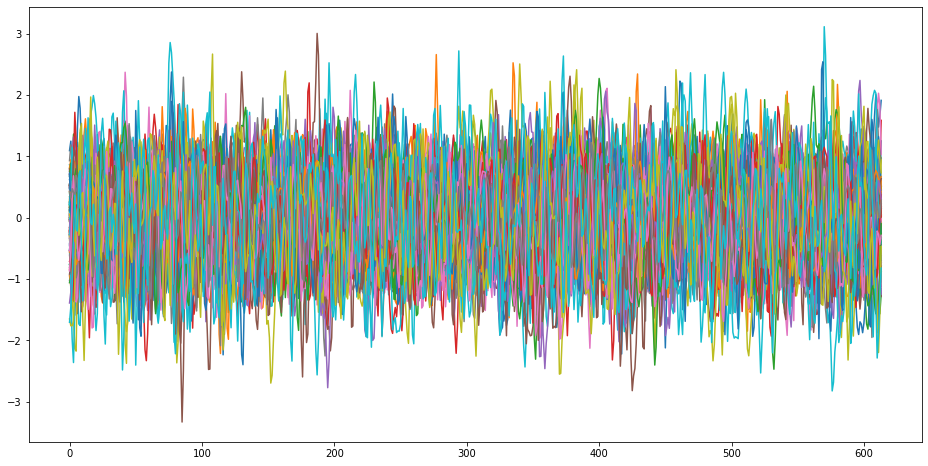

In [ ]:
# Plot first 614 time points for first 100 observations
plt.figure(figsize=(16,8))
for i in range(100):
    plt.plot(range(614),xtrain[i,:614])
plt.show()

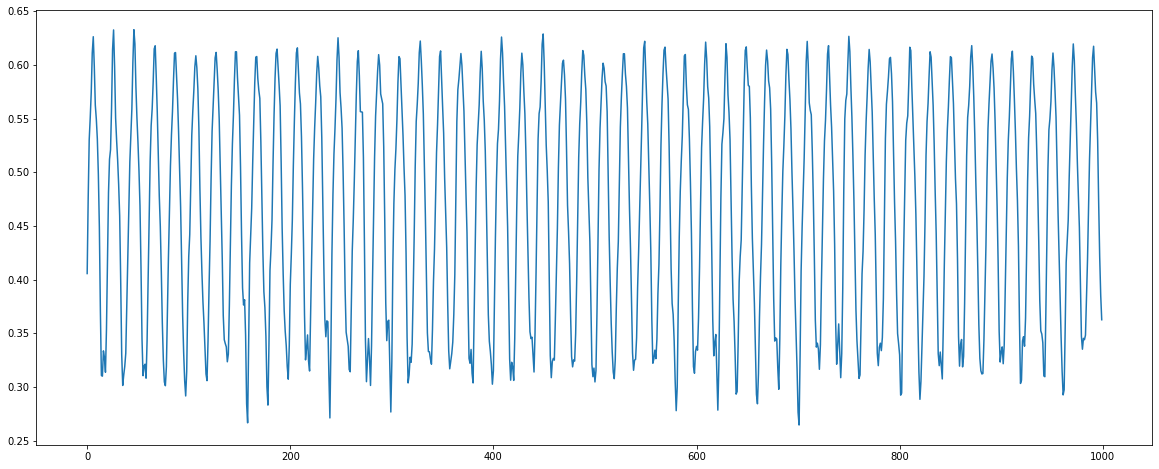

In [ ]:
offset = 3
actual_val = xtrain[10,:1000] 
actual_log = np.log10(actual_val + offset)

plt.figure(figsize=(20,8))
#plt.plot(range(len(actual_val)), actual_val)
plt.plot(range(len(actual_log)), actual_log)
plt.show()

# Functions to plot results

In [ ]:
#Plot 3 first axes of a 2d-matrix with ananomaly score
def display(X, score):

    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c=score, s=20)
    plt.xlabel('X0', fontsize=15), plt.ylabel('X1', fontsize=15)
    plt.xticks(()), plt.yticks(())

    plt.subplot(132)
    plt.scatter(X[:, 1], X[:, 2], c=score, s=20)
    plt.xlabel('X1', fontsize=15), plt.ylabel('X2', fontsize=15)
    plt.xticks(()), plt.yticks(())

    plt.subplot(133)
    plt.scatter(X[:, 0], X[:, 2], c=score, s=20)
    plt.xlabel('X0', fontsize=15), plt.ylabel('X2', fontsize=15)
    plt.xticks(()), plt.yticks(())
    plt.colorbar()
    
    plt.show()
    
    print(score)

In [ ]:
#Plot 2d-matrix (2 features) with different anomaly scores to compare algorithms
def display_multilpe_scores(X, score_lof, score_if, score_svm):

    #plt.figure(figsize=(15, 4))

    fig, axs= plt.subplots(2, 2, figsize=(15,15))
    fig.suptitle('Anomaly scores :')

    #Local outlier factor
    axs[0, 0].scatter(X[:, 0], X[:, 1], c=score_lof, s=20)
    #ax1.xticks(()), ax1.yticks(())
    axs[0, 0].set_title("Local outlier factor score")

    #Isolation Forest 
    axs[0, 1].scatter(X[:, 0], X[:, 1], c=score_if, s=20)
    #ax2.xticks(()), ax2.yticks(())
    axs[0, 1].set_title("Isolation forest")

    #One class svm
    axs[1, 0].scatter(X[:, 0], X[:, 1], c=score_svm, s=20)
    #ax3.xticks(()), ax3.yticks(())
    axs[1, 0].set_title("One class SVM")

    #plt.colorbar()
    
    plt.show()
    
    #print(score)

In [ ]:
#Plot a n-dimention matrix (n features) to 2d-matrix (2 features) with anomaly scores
def plot_pca_tsne(X, score):

  #On applique une pca
  pca   = PCA(n_components=50, whiten = True)
  x_pca = pca.fit_transform(X)

  #Une deuxieme reduction de dimension avec tsne
  tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
  tsne_pca_results = tsne.fit_transform(x_pca)

  plt.figure(figsize=(8, 8))
  sns.scatterplot(
      x=tsne_pca_results[:,0],
      y=tsne_pca_results[:,1],
      hue=score,
      #palette=sns.color_palette('bright', 4135),
      #data=df_subset,
      #legend="full",
      #alpha=0.3
  )

# Mean & Standart deviation features :

Cette approche consiste à réduire chaque enregistrement à 2 dimensions : 
  - La moyenne de ses valeurs au cours du temps
  - L'écart type de ses valeurs

Même si elle figure parmi les premières approches dans ce notebook, cette approche était parmi les dernières approches que j'ai testées, et a produit contre toute attente les meilleurs résultats. Avec plus de temps j'aurais aimé réfléchir aux autres métriques que j'aurais pu ajouter comme dimension au modèle pour améliorer mon score. 

In [ ]:
std_array = []
std_array_test = []

for i in range(len(xtest)):
  #mn, std = np.mean(b[i]), np.std(b[i])
  mn, std = np.mean(xtest[i]), np.std(xtest[i])

  mn_test, std_test = np.mean(xtest[i]), np.std(xtest[i]) 
  std_array.append(np.array([mn, std]))
  std_array_test.append(np.array([mn_test, std_test]))

std_array_test = np.array(std_array_test)
std_array = np.array(std_array)

On affiche un représentaion en 2d du dataset pour avoir un aprerçu de la forme des données.

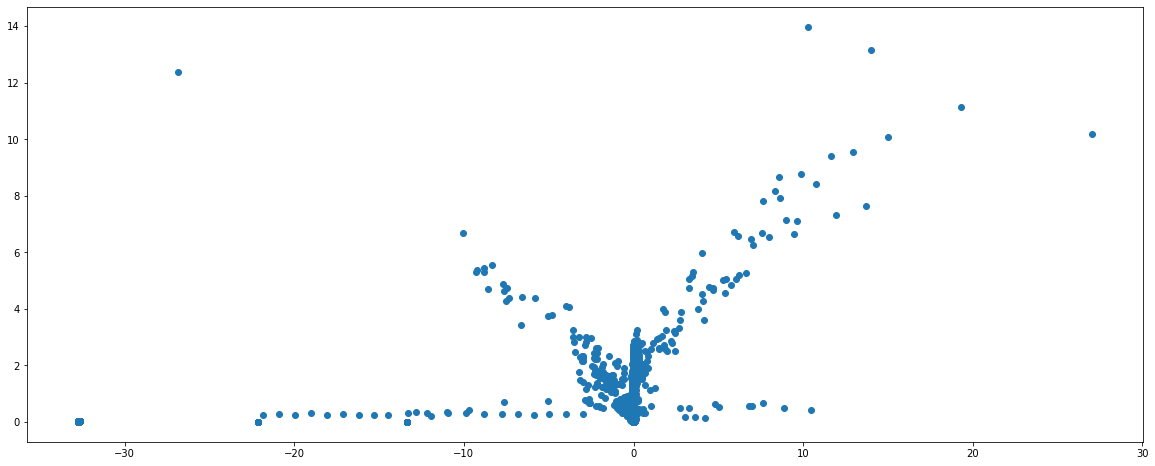

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(std_array[:,0], std_array[:, 1])
plt.show()

De ce qu'on peut voire, on peut imaginer que les outlierssont les points reculés aux extrémités.

## Local outlier factor

In [ ]:
lof1 = LocalOutlierFactor(n_neighbors = 250 , algorithm='kd_tree', contamination = 0.4, leaf_size=70, novelty = True, n_jobs=-1)
lof1.fit(std_array)

LocalOutlierFactor(algorithm='kd_tree', contamination=0.4, leaf_size=70,
                   metric='minkowski', metric_params=None, n_jobs=-1,
                   n_neighbors=250, novelty=True, p=2)

In [ ]:
train_score_lof = -lof1.score_samples(std_array_test) #0.6813

## Isolation Forest 

In [ ]:
clf_IF = IsolationForest(n_estimators = 700, bootstrap = True , contamination='auto', behaviour="new", n_jobs=-1)
clf_IF.fit(std_array)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', bootstrap=True, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=700,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [ ]:
train_score_if = -clf_IF.score_samples(std_array) #0.7373

## One class SVM

In [ ]:
clf_SVM = OneClassSVM(gamma='scale')
clf_SVM.fit(std_array)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [ ]:
train_score_svm = -clf_SVM.score_samples(std_array_test) #0.7273

#### Plot code

In [ ]:
def display_multilpe_scores(X, score_lof, score_if, score_svm):

    #plt.figure(figsize=(15, 4))

    fig, axs= plt.subplots(2, 2, figsize=(15,15))
    fig.suptitle('Anomaly scores :')

    #Local outlier factor
    axs[0, 0].scatter(X[:, 0], X[:, 1], c=score_lof, s=20)
    #ax1.xticks(()), ax1.yticks(())
    axs[0, 0].set_title("Local outlier factor score")

    #Isolation Forest 
    axs[0, 1].scatter(X[:, 0], X[:, 1], c=score_if, s=20)
    #ax2.xticks(()), ax2.yticks(())
    axs[0, 1].set_title("Isolation forest")

    #One class svm
    axs[1, 0].scatter(X[:, 0], X[:, 1], c=score_svm, s=20)
    #ax3.xticks(()), ax3.yticks(())
    axs[1, 0].set_title("One class SVM")

    #plt.colorbar()
    
    plt.show()
    
    #print(score)

On affiche les données avec les scores pour visualiser

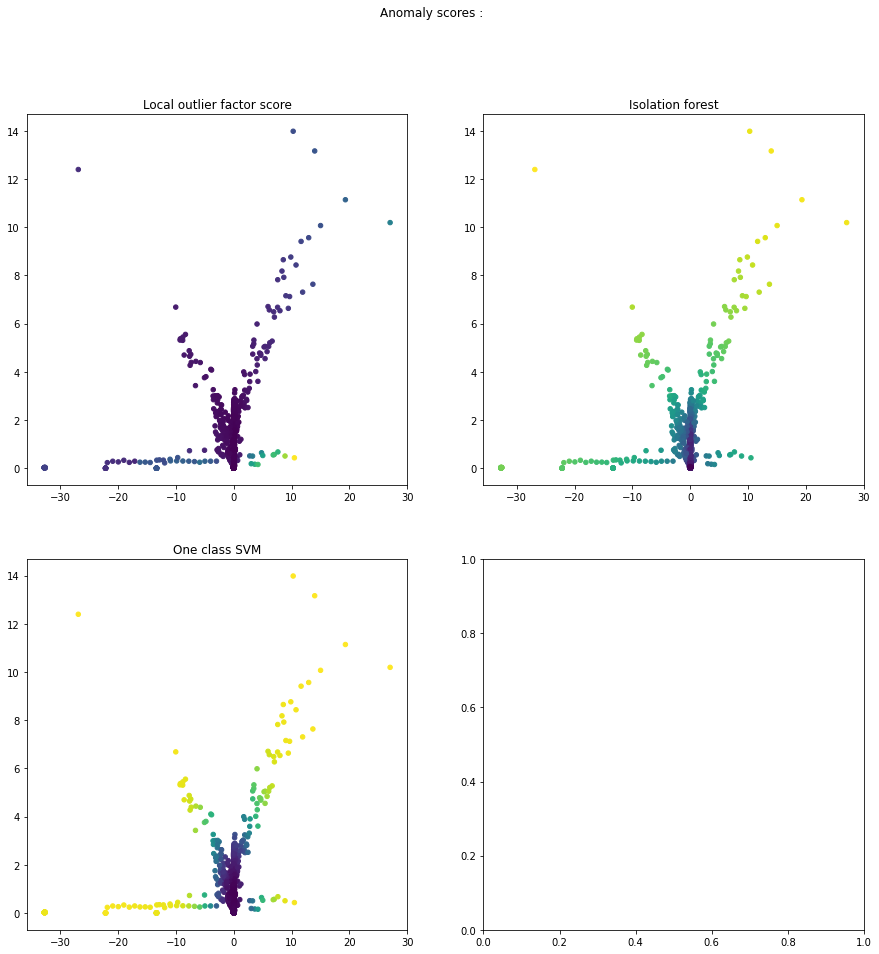

In [ ]:
display_multilpe_scores(std_array,  train_score_lof,  train_score_if, train_score_svm)

On applique t-sne pour essayer d'avoir une visualisation plus claire.

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(std_array)

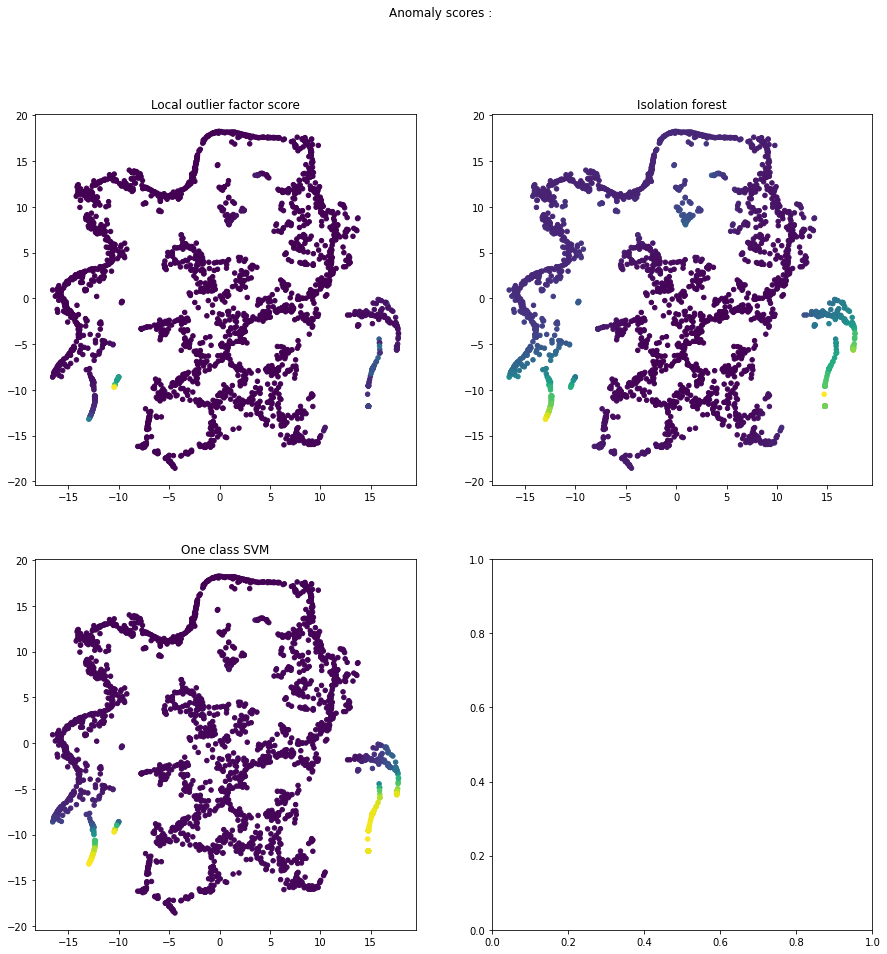

In [ ]:
display_multilpe_scores(tsne_pca_results,  train_score_lof,  train_score_if, train_score_svm)

In [ ]:
# Save the anomaly scores to file
print(train_score_if.shape) #0.72
np.savetxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/ytest_if_exp.csv', train_score_if, fmt = '%1.6f', delimiter=',')

(2511,)


In [ ]:
offset = 4

In [ ]:
a = np.log10(xtest+offset)
b = np.exp(xtest)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [ ]:
train_log, test_log = np.log10(xtrain + offset), np.log10(xtest + offset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


# Frequency analysis :

Les enregistrement traités au cours de ce challenge étant des signaux fréquentiels, l'idée de cette approche était d'essayer de caractériser chaque signal en utilisant sa transformée de Fourrier, et utiliser cette dernière comme dimension d'entrée pour le modèle. Dans mon cas, elle s'est avérée moins performante que j'aurais pu l'espérer.

In [ ]:
def get_fft(L):

  #L = xtest[21]
  # Round because there is a slight variation around actually equals values: 2.762, 2.761 or 1.508, 1.507
  L = [round(elt, 1) for elt in L]

  minima = min(L)
  min_id = L.index(minima)

  start = L.index(minima)
  stop = L[::-1].index(minima)

  L = L[start:len(L)-stop]

  fft = np.fft.fft(np.asarray(L))/len(L)
  fft = fft[range(int(len(L)/2))]

  return abs(fft)

#plt.plot(abs(fft))

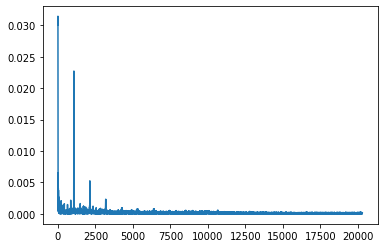

In [ ]:
fft = get_fft(xtest[0])
plt.plot(fft)

In [ ]:
def get_frequecy(x, n_freq=1):

  fft = get_fft(x)

  #We keep only the begining of the fft
  fft = fft[:len(fft)//5]

  sort_fft = np.sort(fft)[::-1]
  list_fft = list(fft)
  freq_list = [list_fft.index(val) for val in sort_fft if list_fft.index(val) > 8][:n_freq]

  #If the freq_list is empty due to some errors during fft computing, we fill it with 0
  if len(freq_list) == 0:
    freq_list = n_freq * [0]

  return freq_list

In [ ]:
idx_list = get_frequecy(xtest[0])

In [ ]:
idx_list

[1065]

In [ ]:
def get_all_signals_freq(X):
  freq_dim = [get_frequecy(signal)[0] for signal in X ]
  return freq_dim

Add a frequency dimension to our data

In [ ]:
np.shape(std_array)

(2511, 2)

In [ ]:
x_fft = []
for row in xtest:
  fft = get_fft(row)
  x_fft.append(list(fft))

In [ ]:
list_mean_fft = []
list_std_fft = []

for x in x_fft:

  if(len(x) != 0 ):
    fft_mean, fft_std = np.mean(x), np.std(x)
  else:
     fft_mean, fft_std = 0, 0

  list_mean_fft.append(fft_mean)
  list_std_fft.append(fft_std)

In [ ]:
std_array_freq = np.insert(std_array, np.shape(std_array)[1], list_mean_fft, axis=1)
std_array_freq = np.insert(std_array_freq, np.shape(std_array_freq)[1], list_std_fft, axis=1)

### Local outlier factor

In [ ]:
lof1 = LocalOutlierFactor(n_neighbors = 210 , algorithm='ball_tree', metric='chebyshev', contamination = 0.4, leaf_size=70, novelty = True, n_jobs=-1)
lof1.fit(std_array_freq)

LocalOutlierFactor(algorithm='ball_tree', contamination=0.4, leaf_size=70,
                   metric='chebyshev', metric_params=None, n_jobs=-1,
                   n_neighbors=210, novelty=True, p=2)

In [ ]:
train_score_lof_freq = -lof1.score_samples(std_array_freq) #0.72

### Isolation forest 

In [ ]:
clf_IF = IsolationForest(n_estimators = 700, bootstrap = True , contamination='auto', behaviour="new", n_jobs=-1)
clf_IF.fit(std_array_freq)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', bootstrap=True, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=700,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [ ]:
train_score_if_freq = -clf_IF.score_samples(std_array_freq) #0.61

### One class SVM

In [ ]:
clf_SVM = OneClassSVM(gamma='scale')
clf_SVM.fit(std_array_freq)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [ ]:
train_score_svm = -clf_SVM.score_samples(std_array_freq) #0.7273

### Display results scores on data

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results_1 = tsne.fit_transform(std_array)

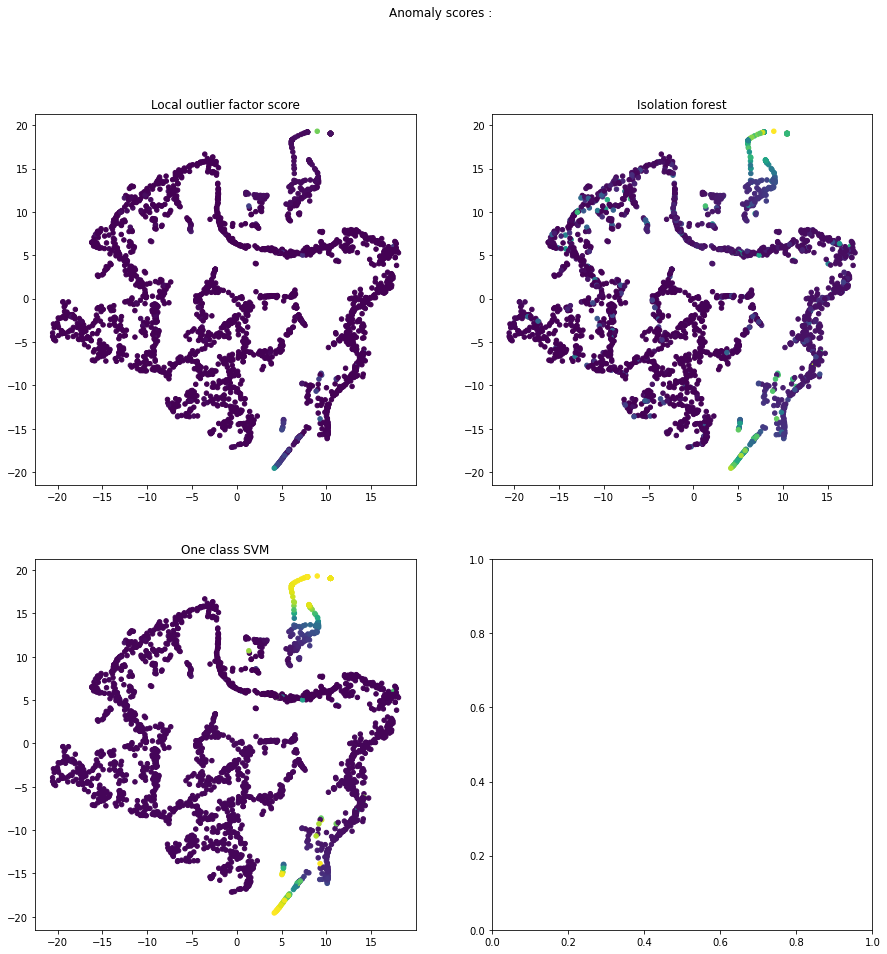

In [ ]:
display_multilpe_scores(tsne_pca_results_1, train_score_lof_freq,  train_score_if_freq, train_score_svm)

plot tsne 2

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(std_array_freq)

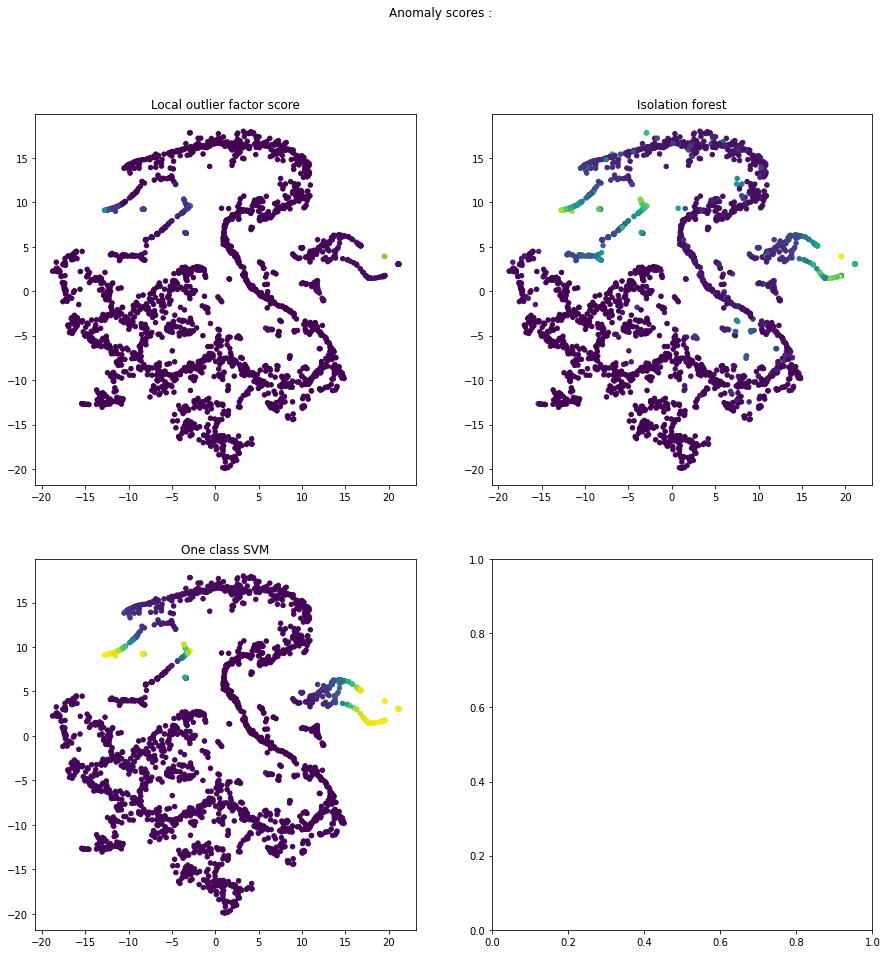

In [ ]:
display_multilpe_scores(tsne_pca_results, train_score_lof_freq,  train_score_if_freq, train_score_svm)

### File submission

In [ ]:
# Save the anomaly scores to file
print(train_score_svm.shape) #0.72
np.savetxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/ytest_if_freq.csv', train_score_if_freq, fmt = '%1.6f', delimiter=',')

(2511,)


chebychev : 0.73 - ball_tree

# Possible option: Using the projection on a low-dimensional space

Approche proposée en exemple pour le challenge.

In [ ]:
# PCA transform
pca1 = PCA(n_components = 10, whiten = True)
pca1.fit(xtrain)
xtrain_fpca = pca1.fit_transform(xtrain)

In [ ]:
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 'auto', novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
sscore = -lof1.score_samples(xtest_fpca)
print(sscore[:100])

[2.30495283 3.19059253 2.32716537 5.24916789 3.75148298 2.48189046
 1.60438698 2.08630002 3.62564325 1.51526992 2.32950666 2.50216365
 2.53171923 3.6782696  2.54456761 1.73768816 3.76004812 2.79062235
 2.96427231 2.00568815 2.59458622 2.36526924 2.06220579 4.85722909
 3.93695441 2.29723427 2.2837554  2.82365    2.22172254 3.40772336
 2.33723465 2.77095642 2.58092923 2.23660858 2.6577842  6.02312685
 1.74127076 3.02981272 2.63457729 3.8907132  2.94835605 2.92677846
 3.13101707 2.79703773 2.46178189 3.23516602 2.10563248 2.90870169
 2.07456443 3.21477666 2.48678851 2.07894139 2.86776303 2.5332558
 1.72091179 2.12382248 2.28507431 2.07835612 2.32759383 2.3938174
 1.88185871 2.75304501 1.88286452 2.6515637  2.63940144 2.40312451
 2.59363035 2.39124105 3.26054337 3.12825019 3.19957607 2.84831279
 3.11522775 2.74022748 2.23246432 2.23009677 3.0253895  2.5821785
 1.96329881 2.42200071 2.29115511 3.31083657 2.23186978 2.27524304
 2.72763017 1.3624021  2.76370224 3.48196774 2.90468994 2.8084799

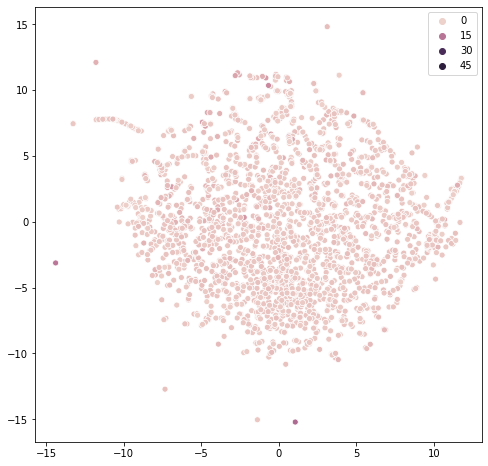

In [ ]:
plot_pca_tsne(xtest, sscore)

## Prepare a file for submition

In [ ]:
# Save the anomaly scores to file
print(sscore.shape)
np.savetxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/ytest_challenge_student.csv', sscore, fmt = '%1.6f', delimiter=',')

(2511,)


## Time-series forecasting

Une approche serait de considérer les signaux comme des séries temporelles, d'analyser chaque signal à l'instant **t** ([0-t]), pour prédire la valeur à valeur à l'instant **t+1**.

Les outliers sont celles dont les valeurs prédites s'éloignent trop des valeurs réelles.


**<u>Update</u>**: Cette approche s'est avérée trop couteuse en temps de calcul, je n'ai pas pu l'implémenter jusqu'au bout.

### Try forecasting with ARIMA model

L'idé ici était de d'essayer de prédire la valeur du signal à l'instant **t+1** en fonctions des valeurs aux instants t précédents.

Il serait ensuite question de comparer la valeur prédite avec la valeur réelle. Ainsi, les outliers aurient été les valeurs trop éloignées des valeurs prédites.

Mais j'ai abandonné cette piste à cause d'un problème d'overfitting sur les données d'entrainement. Très probablement à cause du paramétrage du modèle ARIMA.

Je reviendrait sur cette aproche un peu plus tard pour essayer de trouver les bons paramètres du modèle.

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
!pip3 install pmdarima statsmodels

In [ ]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
#import plotly.plotly as py
#import plotly.tools as tls

In [ ]:
train, test = actual_val[0:-200], actual_val[-200:]
train_log, test_log = np.log10(train + offset), np.log10(test + offset)

In [ ]:
my_order = (1, 1, 1)
my_seasonal_order = (0, 1, 1, 60)

In [ ]:
history = [x for x in train_log]
predictions = list()
predict_log=list()

In [ ]:

for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(history, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0] - offset
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


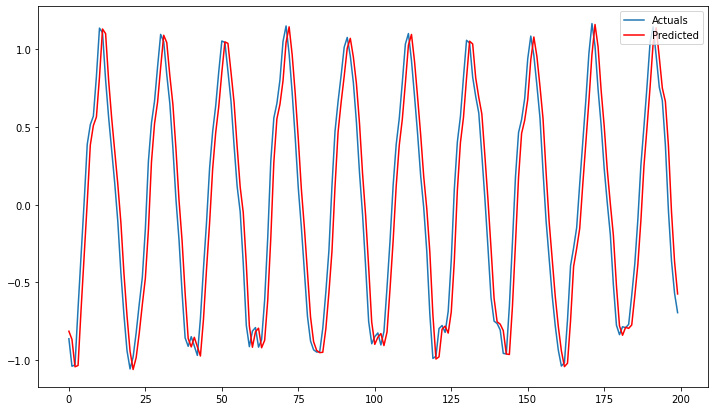

In [ ]:
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

Nous essayons de prédire la périodicité du signal avec un auto-Arima.

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
stepwise_model = auto_arima(train_log, start_p=1, start_q=1,
                           max_p=3, max_q=3,
                           start_P=0, seasonal=True,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
history = [x for x in train_log]
predictions = list()
predict_log=list()

In [ ]:
for t in range(len(test_log)):
    #model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    stepwise_model.fit(history)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0] - offset
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    #print(t)

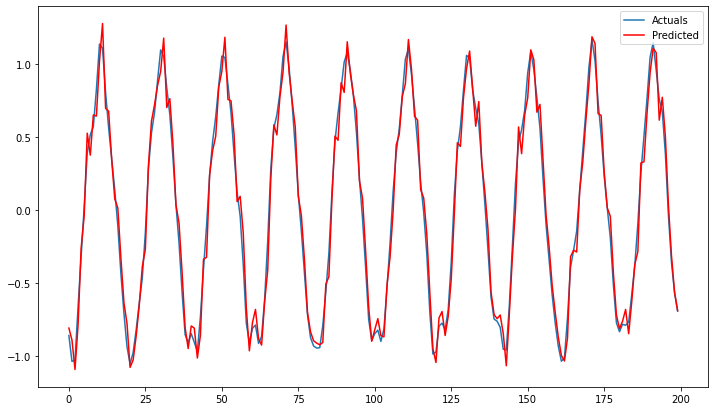

In [ ]:
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

Stationarité : 

On effectue un test pour tester la stationarité de la série. L'hypothèse nulle est que le test est non-stationaire. Donc si la p-value est moins que le niveau de significativité, alors on rejette l'hypothèe nulle. Le signal serait alors stationaire.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(xtrain[10,:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Simple PCA :

On applique un pca au dataset, pour réduire la dimension du dataset, tout en essayant de garder le maximum de variance des données.

In [ ]:
pca   = PCA(n_components=0.99,whiten = True)
xtrain_fpca = pca.fit_transform(X)

In [ ]:
pca   = PCA(n_components=0.99,whiten = True)
xtrain_fpca = pca.fit_transform(X_train)

In [ ]:
print("X_train_pca shape : {}".format(xtrain_fpca.shape))

In [ ]:
pca   = PCA(n_components=917,whiten = True)
xtest_fpca = pca.fit_transform(X_test)
print("X_test_pca shape : {}".format(xtest_fpca.shape))

## Local outlier factor

n_components = 308
score = 0.54

In [ ]:
lof1 = LocalOutlierFactor(n_neighbors = 250 , algorithm='kd_tree', contamination = 0.01, leaf_size=50, novelty = True, n_jobs=-1)
lof1.fit(xtrain_fpca)

In [ ]:
train_score_lof = -lof1.score_samples(xtest_fpca)

In [ ]:
plot_pca_tsne(xtest_fpca, train_score_lof)

## Isolation forest

pca n_components : 915
score = 0.55

In [ ]:
clf_IF = IsolationForest(n_estimators = 500, bootstrap = True, contamination='auto', behaviour="new", n_jobs=-1)
clf_IF.fit(xtrain_fpca)

In [ ]:
score_IF = -clf_IF.score_samples(xtest_fpca)
#display(X_pca, score_IF)

In [ ]:
plot_pca_tsne(xtest_fpca, score_IF)

ON essaye un Isolation forest sur l'ensemble des données (entrainement + test) pour mieux visualiser les performances du modèle.

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


#Apply pca
pca   = PCA(n_components=50,whiten = True)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)

#xtrain_pca = pca.fit_transform(xtrain_fpca)
#xtest_pca = pca.fit_transform(xtest_fpca)

xtrain_pca = pca.fit_transform(xtrain)
xtest_pca = pca.fit_transform(xtest)

#Apply t-sne
tsne_pca_train = tsne.fit_transform(xtrain_pca)
tsne_pca_test = tsne.fit_transform(xtest_pca)

# fit the model
clf = IsolationForest(n_estimators=800, max_samples=300, contamination=0.05)
clf.fit(tsne_pca_train)
y_pred_train = clf.predict(tsne_pca_train) #Train
y_pred_test = clf.predict(tsne_pca_test) #test
test_score = clf.score_samples(tsne_pca_test) #test

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(12, 8))

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(tsne_pca_train[:, 0], tsne_pca_train[:, 1], c='r',
                 s=20, edgecolor='k') # Mettre b1 en commentaire pour afficher uniquement les données
                                      # de test (faire pareil avec b2 pour les données de test)
b2 = plt.scatter(tsne_pca_test[:, 0], tsne_pca_test[:, 1], c=test_score,
                 s=20, edgecolor='k') 

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2],
           ["training observations",
            "new regular observations"],
           loc="upper left")
plt.show()

Les points rouges sont des données de d'entrainement. **La couleur des scores est appliquée uniquement sur les données de test.**

In [ ]:
np.savetxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/y_if.csv', test_score, fmt = '%1.6f', delimiter=',')

In [ ]:
# Save the anomaly scores to file
print(score_.shape)
np.savetxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/ytest_if_2.csv', score_, fmt = '%1.6f', delimiter=',')

## One class SVM

pca components : 915
score :  0.520012174472

In [ ]:
clf_SVM = OneClassSVM(gamma='scale')
clf_SVM.fit(xtrain_fpca)

In [ ]:
#plot results
score_SVM = -clf_SVM.score_samples(xtest_fpca)
#display(xtrain_fpca, score_SVM)

In [ ]:
display(xtest_fpca, score_SVM)

In [ ]:
plot_pca_tsne(xtest, score_SVM)

In [ ]:
# Save the anomaly scores to file
print(score_SVM.shape)
np.savetxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/ytest_svm.csv', score_SVM_test, fmt = '%1.6f', delimiter=',')

## DBSCAN:

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
outlier_detection_DBSCAN = DBSCAN(
            #eps = .2, 
            algorithm = 'ball_tree',
            metric="euclidean", 
            min_samples = 10,
            n_jobs = -1)


In [ ]:
clusters = outlier_detection_DBSCAN.fit_predict(xtest)

In [ ]:
a = outlier_detection_DBSCAN.fit(X)

In [ ]:
plot_pca_tsne(xtest, clusters)

In [ ]:
# Save the anomaly scores to file
print(clusters.shape)
np.savetxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/ytest_dbscan.csv', clusters, fmt = '%1.6f', delimiter=',')

# Autoencoder

L'idée dans cette approche était d'utiliser un Autoencoder pour encoder puis décoder chaque signal, en calculant un erreur à chaque fois.

Les outliers seraient donc les signaux avec un taux d'erreur relativement élevé.

Si cette approche a apporté des résultats encouragents (Score autour de 70), elle s'est avérée moins efficace que je l'espérais, malgré les différentes architectures testées. Celà se manifestait aussi par la loss du jeu de validation qui ne diminuait pas au cours de l'entrainement, comme si le modèle n'arrivait pas à apprendre.

**N.B :** J'ai d'abord utilisé la librairie **PyOd**, puis j'ai essayé de contruire intégralement mon autoencoder à la main.

Exemples d'architectures testées :

 - Model 1: [data.shape, 25, 2, 2, 25, data.shape].

 - Model 2: [data.shape, 25, 10, 2, 10, 25, data.shape].

 - Model 3: [data.shape, 25, 15, 10, 2, 10, 15, 25, data.shape].

In [ ]:
!pip install pyod

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder

Using TensorFlow backend.


In [ ]:
X_train = StandardScaler().fit_transform(xtrain)
X_test = StandardScaler().fit_transform(xtest)

Dimesion reduction with pca

In [ ]:
pca   = PCA(n_components=0.99, whiten = True)
xtrain_pca = pca.fit_transform(X_train)
np.shape(xtrain_pca)

(1677, 917)

In [ ]:
pca   = PCA(n_components=917, whiten = True)
xtest_pca = pca.fit_transform(X_test)
np.shape(xtest_pca)

(2511, 917)

## Model 1 — Step 1 — Build the model

In [ ]:
clf1 = AutoEncoder(hidden_neurons=[300, 32, 2 ,2, 32, 300], dropout_rate=0.05, validation_size=0.05, epochs=30)
clf1.fit(xtrain_pca)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 917)               841806    
_________________________________________________________________
dropout_7 (Dropout)          (None, 917)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 917)               841806    
_________________________________________________________________
dropout_8 (Dropout)          (None, 917)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 300)               275400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)               

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.05, epochs=30,
      hidden_activation='relu', hidden_neurons=[300, 32, 2, 2, 32, 300],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fb61ab77158>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.05, verbose=1)

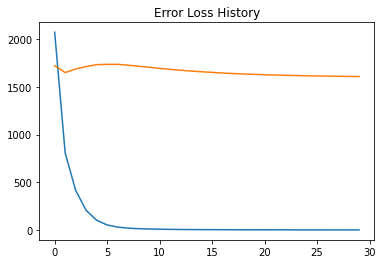

In [ ]:
plt.plot(clf1.history_['loss'])
plt.plot(clf1.history_['val_loss'])
plt.title('Error Loss History')
plt.show()

## Model 1 — Step 2 — Determine the Cut Points

In [ ]:
# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

In [ ]:
# Predict the anomaly scores
y_test_scores = clf1.decision_function(xtest_pca)  # outlier scores
#y_test_scores = pd.Series(y_test_scores)

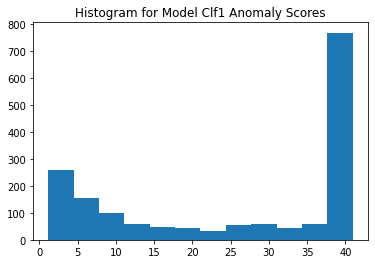

In [ ]:
# Plot it!
#import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

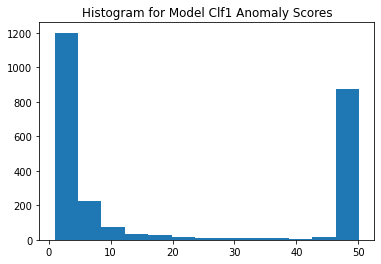

In [ ]:
# Plot it!
#import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

On définit comme anomalies les entrées dont le score est entre 20 et 45

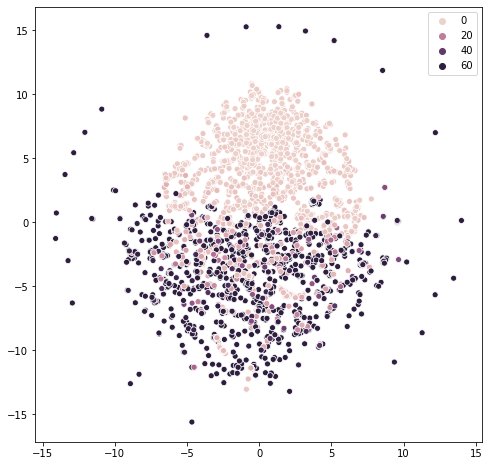

In [ ]:
plot_pca_tsne(xtest_pca, y_test_scores)

## File submission

In [ ]:
c = np.mean(abs(x_pred - X_test), axis = 1)

In [ ]:
# Save the anomaly scores to file
print(c.shape)
np.savetxt('/content/drive/My Drive/TELECOM/MDI_341_Challenge/ytest_Autoencoder_2.csv', c, fmt = '%1.6f', delimiter=',')

(2511,)


## Model 2 - Handmade autoencoder

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [ ]:
#Reshape inputs for LSTM 
a = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
b = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
def autoenconder_model(X):

  inputs = Input(shape=(X.shape[1], X.shape[2]))

"""
  #L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = LSTM(2, activation='relu', return_sequences=False )(inputs)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(2, activation='relu', return_sequences=True)(L3)
  #L5 = LSTM(16, activation='relu', return_sequences=True)(L4)

  outputs = TimeDistributed(Dense(X.shape[2]))(L4)
  model = Model(inputs=inputs, outputs=outputs) """

  input_dim = X.shape[1] # the # features
  encoding_dim = 8 # first layer
  hidden_dim = int(encoding_dim / 2) #hideen layer

  input_layer = Input(shape=(input_dim, ))

  encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(inputs)
  encoder = Dense(hidden_dim, activation="relu")(encoder)
  decoder = Dense(encoding_dim, activation='relu')(encoder)
  decoder = Dense(input_dim, activation='tanh')(decoder)
  autoencoder = Model(inputs=input_layer, outputs=decoder)

  return model



In [ ]:
#On crée le modèle d'autoencoder
model = autoenconder_model(a)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 61440)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 2)                 491544    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 2)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 2)              40        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 61440)          184320    
Total params: 675,904
Trainable params: 675,904
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit the model
nb_epoch = 100
batch_size = 128
learning_rate = 0.1

history = model.fit(a, a, batch_size=batch_size, epochs=nb_epoch, validation_split=0.05 ).history

Train on 1593 samples, validate on 84 samples
Epoch 1/100
1593/1593 [==============================] - 1s 683us/step - loss: 0.5727 - val_loss: 0.3611
Epoch 2/100
1593/1593 [==============================] - 1s 645us/step - loss: 0.5726 - val_loss: 0.3611
Epoch 3/100
1593/1593 [==============================] - 1s 652us/step - loss: 0.5726 - val_loss: 0.3612
Epoch 4/100
1593/1593 [==============================] - 1s 658us/step - loss: 0.5726 - val_loss: 0.3612
Epoch 5/100
1593/1593 [==============================] - 1s 658us/step - loss: 0.5725 - val_loss: 0.3612
Epoch 6/100
1593/1593 [==============================] - 1s 651us/step - loss: 0.5725 - val_loss: 0.3612
Epoch 7/100
1593/1593 [==============================] - 1s 645us/step - loss: 0.5725 - val_loss: 0.3612
Epoch 8/100
1593/1593 [==============================] - 1s 648us/step - loss: 0.5725 - val_loss: 0.3613
Epoch 9/100
1593/1593 [==============================] - 1s 645us/step - loss: 0.5724 - val_loss: 0.3613
Epoch 10/

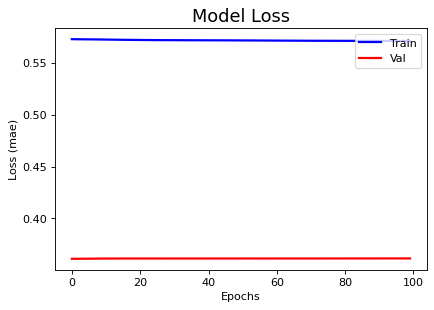

In [ ]:
#Plot train loss
fig, ax = plt.subplots(dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Val', linewidth=2)
ax.set_title('Model Loss', fontsize=16)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (mae)')
ax.legend(loc='upper right')
plt.show()

In [ ]:
#Plot loss distribution
x_pred = model.predict(b)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])

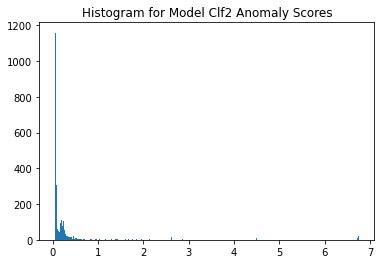

In [ ]:
#Plot error histogram
plt.hist(c, bins='auto')  
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

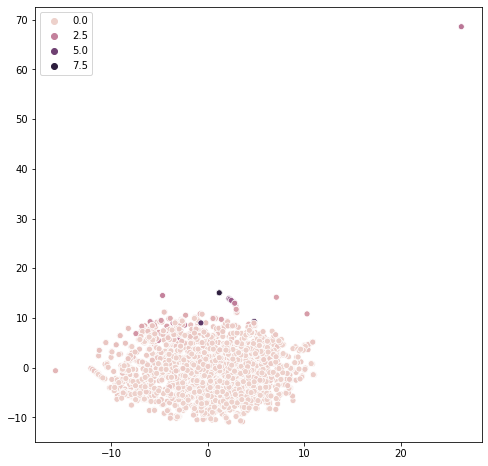

In [ ]:
#Display data with scores
plot_pca_tsne(X_test, c)

# Conclusion :

Au cours ce challenge, il était question d'essayer de déterminer les signaux anormaux par le biais de diverses méthodes.

Pour le accomplir ce challenge, j'ai testé plusieurs approches, d'abord pour etraire les features les plus pertinentes.

Parallèlement à ces approches de transformation de features, j'ai testé divers algorithmes d'entrainement de modèles.

A ma grande surprise, la fabrication de features simples en se basant sur le calcul de la moyenne et de l'écart type a produit les meilleurs resultats. je ne l'ai découvert que dans la dernière ligne droite du challenge.

Avec plus de temps j'aurais donc aimé trouver d'autres métriques intéressantes, et essayer de trouver comment mieux paramétrer les approches avec les modèles ARIMA et les Autoencodeurs. 